In [ ]:
!pip install -q kaggle

Acesse https://www.kaggle.com/ e crie sua conta. Entre nas configurações da sua conta e clique em **Create New Token**. Faça o upload do arquivo usando o código abaixo.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"otaviocozer","key":"a0d0b6bb92ca10ebd24e1371edf6d7ab"}'}

Use o código abaixo para montar o seu drive e poder salvar seu modelo e os gráficos de loss.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Crie a pasta inference aonde serão guardadas as detecções realizadas pelo seu modelo, e baixe o dataset.

In [ ]:
!mkdir inference

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lgmoneda/br-coins

 99% 931M/945M [00:11<00:00, 61.2MB/s]
100% 945M/945M [00:11<00:00, 83.5MB/s]


In [ ]:
!unzip /content/br-coins.zip

Abaixo estão os imports necessários e também algumas constantes que serão usadas, você pode mudar esses valores mais a frente caso precise. Apenas lembre-se de definir a constante **OUT_DIR** com o caminho desejado para salvar o seu melhor modelo e os gráficos de loss.

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import glob as glob
import os

import cv2
from google.colab.patches import cv2_imshow

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

BATCH_SIZE = 8 # increase / decrease according to GPU memeory
RESIZE_TO = 480 # resize the image for training and transforms
NUM_WORKERS = 2

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

IMAGES_DIR = 'COCO_labelme_regression/regression'

IMAGE_PATHS = glob.glob(f"{IMAGES_DIR}/*.jpg")
ALL_IMAGES = [image_path.split(os.path.sep)[-1] for image_path in IMAGE_PATHS]

TRAIN_IMAGES, VALIDATION_IMAGES = torch.utils.data.random_split(ALL_IMAGES, [0.8, 0.2])

TRAIN_IMAGES, VALIDATION_IMAGES = sorted(TRAIN_IMAGES), sorted(VALIDATION_IMAGES)

CLASSES = ['__background__', '5', '10', '25', '50', '100']

NUM_CLASSES = len(CLASSES)

VISUALIZE_TRANSFORMED_IMAGES = True

######################################################################
# SUBSTITUA PELA PASTA NO SEU DRIVE AONDE DESEJA SALVAR SEU MODELO E OS GRÁFICOS DE LOSS
OUT_DIR = "/content/gdrive/MyDrive/Lab4"
######################################################################


Para implementar o modelo de detecção precisamos importar a faster_rcnn do pytorch já treinada e fazer o fine tunning para a nossa aplicação, também é preciso alterar a última camada para fazer a previsão baseada no número de classes do nosso problema. Você pode encontrar essas informações aqui: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
  model = None

  ######################################################################
  # SUBSTITUA PASS PELO SEU CÓDIGO
  pass
  ######################################################################

  return model

Use o código abaixo para verificar se o modelo é da classe correta.

In [ ]:
x = create_model(2)
type(x)
assert type(x) is torchvision.models.detection.faster_rcnn.FasterRCNN

In [ ]:
class Averager:
  def __init__(self):
    self.current_total = 0.0
    self.iterations = 0.0

  def send(self, value):
    self.current_total += value
    self.iterations += 1

  @property
  def value(self):
    if self.iterations == 0:
        return 0
    else:
        return 1.0 * self.current_total / self.iterations

  def reset(self):
    self.current_total = 0.0
    self.iterations = 0.0

class SaveBestModel:
  def __init__(self, best_valid_loss=float('inf')):
    self.best_valid_loss = best_valid_loss

  def __call__(self, current_valid_loss, epoch, model, optimizer, dir):
    if current_valid_loss < self.best_valid_loss:
      self.best_valid_loss = current_valid_loss
      print(f"\nBest validation loss: {self.best_valid_loss}")
      print(f"\nSaving best model for epoch: {epoch+1}\n")
      torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),}, f'{dir}/best_model.pth')

def collate_fn(batch):
  return tuple(zip(*batch))


Abaixo estamos definindo o CustomDataset e o DataLoader que serão responsáveis por alimentar nosso modelo com os exemplos de treinamento e validação. Você deve implementar a função **\_\_getitem\_\_ de CustomDataset**. Essa função deve ler a **i-ésima** imagem e o seu json correspondente e deve retornar um Tensor e um Dict. A imagem é lida como um array com valores de 0 a 255 e de dimensões **HWC**, onde **C** é o número de canais de cores, e deve ser convertida para um tensor de dimensões **CHW** com valores de 0 até 1. O Dict deve conter um Tensor de **boxes** no formato (xmin, ymin, xmax, ymax) e um Tensor de **labels** correspondente. Lembrando que as imagens e as boxes devem ter o seu tamanho redimensionado. Cada json de anotações contém uma lista de **shapes** que podem ser **finger** ou qualquer uma das nossas 5 labels, os fingers devem ser ignorados. Os objetos de interesse, as moedas, podem ser definidos como **circle** ou **polygons**. Aqueles definidos como circle tem dois pontos correspondendo ao centro e a um ponto qualquer no exterior da moeda. Já aqueles definidos como polígonos são uma coleção de pontos que definem o contorno da moeda.


In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dir_path, width, height, classes, all_images):
    self.dir_path = dir_path
    self.width = width
    self.height = height
    self.classes = classes
    self.all_images = all_images

  def __getitem__(self, idx):
    image_resized, target = None, None
    ######################################################################
    # SUBSTITUA PASS PELO SEU CÓDIGO
    pass
    ######################################################################

    return image_resized, target

  def __len__(self):
    return len(self.all_images)

def create_train_dataset():
  train_dataset = CustomDataset(IMAGES_DIR, RESIZE_TO, RESIZE_TO, CLASSES, TRAIN_IMAGES)
  return train_dataset
def create_valid_dataset():
  valid_dataset = CustomDataset(IMAGES_DIR, RESIZE_TO, RESIZE_TO, CLASSES, VALIDATION_IMAGES)
  return valid_dataset

def create_train_loader(train_dataset, num_workers=0):
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
  return train_loader
def create_valid_loader(valid_dataset, num_workers=0):
  valid_loader = DataLoader(valid_dataset,batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
  return valid_loader

Use o código abaixo para testar se a sua implementação está correta.

Number of training images: 4817


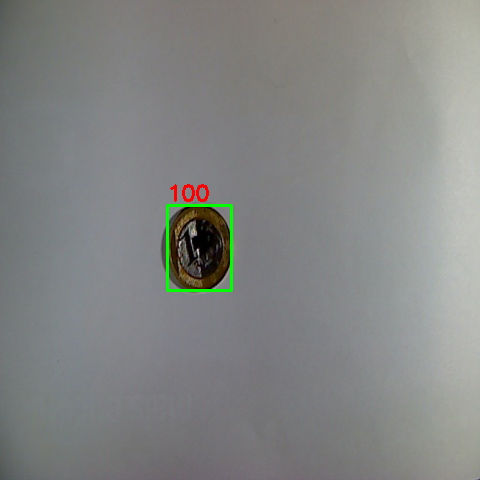

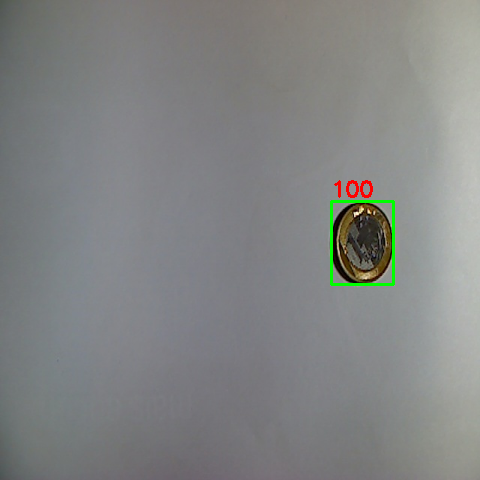

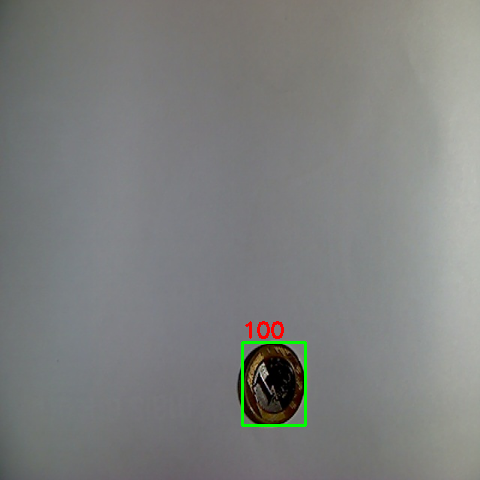

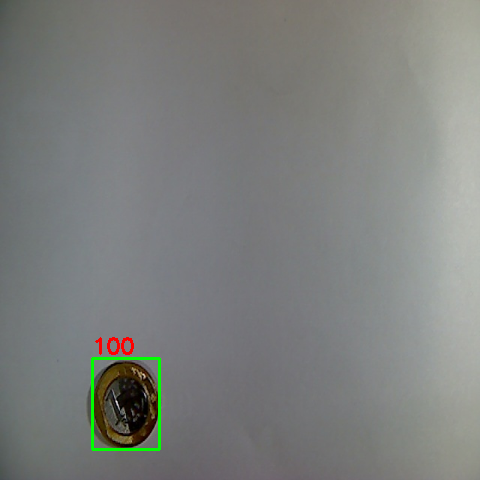

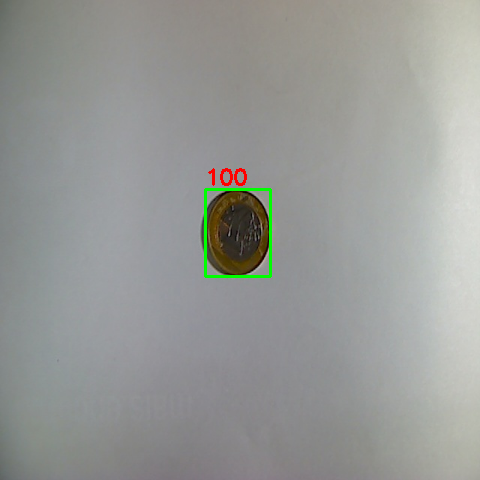

In [ ]:
IMAGES = ["10_1477289016.jpg", "25_1477149534.jpg", "130_1477862364.jpg",
          "10_1477186224.jpg", "135_1479426018.jpg", "100_1477195278.jpg",
          "75_1477849572.jpg", "100_1477195260.jpg", "5_1477145532.jpg"]
dataset = CustomDataset(IMAGES_DIR, RESIZE_TO, RESIZE_TO, CLASSES, IMAGES)
print(f"Number of training images: {len(dataset)}")

for i in range(5):
  image, target = dataset[i]
  image = image.permute(1, 2, 0).data.numpy() * 255.0
  for box_num in range(len(target['boxes'])):
    box = target['boxes'][box_num]
    label = CLASSES[target['labels'][box_num]]
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),(0, 255, 0), 2)
    cv2.putText(image, label, (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

  cv2_imshow(image)

Agora, implemente a **função train** que é responsável por treinar o modelo por uma Epoch. Para cada loop da função teremos uma batch de images e os seus respectivos targets contendo os boxes e labels. Você deve fazer um forward pass, um backward pass, calcular a loss para essa batch e atualizar a loss média para a Epoch assim como a train_loss_hist. Repita o mesmo processo para a **função validate** e lembre-se de desavitar o gradiente na forward pass e de não realizar o backward pass. Você pode usar como referência as funções **train_one_epoch** e **evaluate** do pytorch: https://github.com/pytorch/vision/blob/main/references/detection/engine.py

In [ ]:
def train(train_data_loader, model):
  print('Training')
  global train_itr
  global train_loss_list

  prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

  for i, data in enumerate(prog_bar):
    optimizer.zero_grad()
    images, targets = data
    loss_value = None

    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    ######################################################################
    # SUBSTITUA PASS PELO SEU CÓDIGO
    pass
    ######################################################################

    optimizer.step()
    train_itr += 1

    prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
  return train_loss_list

def validate(valid_data_loader, model):
  print('Validating')
  global val_itr
  global val_loss_list

  prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

  for i, data in enumerate(prog_bar):
    images, targets = data
    loss_value = None

    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    ######################################################################
    # SUBSTITUA PASS PELO SEU CÓDIGO
    pass
    ######################################################################

    val_itr += 1

    prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
  return val_loss_list

Agora treine a sua rede até o overfit em um pequeno dataset para testar o seu código. Caso dê tudo certo você pode treinar o seu modelo por 10 Epochs em todos os dados, isso leva aproximadamente 2 horas.

In [ ]:
NUM_EPOCHS = 5
TRAIN_IMAGES, VALIDATION_IMAGES, _ = torch.utils.data.random_split(ALL_IMAGES, [0.008, 0.002, 0.99])
TRAIN_IMAGES, VALIDATION_IMAGES = sorted(TRAIN_IMAGES), sorted(VALIDATION_IMAGES)

In [ ]:
train_dataset = create_train_dataset()
valid_dataset = create_valid_dataset()
train_loader = create_train_loader(train_dataset, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

save_best_model = SaveBestModel()

for epoch in range(NUM_EPOCHS):
  print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

  train_loss_hist.reset()
  val_loss_hist.reset()

  start = time.time()
  train_loss = train(train_loader, model)
  val_loss = validate(valid_loader, model)
  print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
  print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
  end = time.time()
  print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

  save_best_model(val_loss_hist.value, epoch, model, optimizer, OUT_DIR)

  torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), }, f'{OUT_DIR}/last_model.pth')

  figure_1, train_ax = plt.subplots()
  figure_2, valid_ax = plt.subplots()
  train_ax.plot(train_loss, color='tab:blue')
  train_ax.set_xlabel('iterations')
  train_ax.set_ylabel('train loss')
  valid_ax.plot(val_loss, color='tab:red')
  valid_ax.set_xlabel('iterations')
  valid_ax.set_ylabel('validation loss')
  figure_1.savefig(f"{OUT_DIR}/train_loss.png")
  figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
  print('SAVING PLOTS COMPLETE...')

  plt.close('all')

Use o seu modelo ou aquele oferecido pelo professor para desenhar as caixas e os labels previstos em todas as imagens do dataset. Faça as transformações necessárias para na imagem para a forward pass mas não a redimensione.Você deve desativar o gradiente e realizar a forward pass, o retorno será da forma List\[Dict\[Tensor\]\] para cada imagem de entrada. O Dict possui os campos boxes\[N, 4\], labels\[N\] e scores \[N\]. Desenhe apenas as boxes com score maior que **detection_threshold**. Você pode encontrar mais informações em: https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn


In [ ]:
model = create_model(num_classes=NUM_CLASSES)

####################
# PASSE O CAMINHO DO SEU MELHOR MODELO
BEST_MODEL_PATH = None
####################
best_model = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(best_model['model_state_dict'])
model.to(DEVICE).eval()

print(f"Test instances: {len(ALL_IMAGES)}")

detection_threshold = 0.8

for i in range(len(ALL_IMAGES)):
  # get the image file name for saving output later on
  image_name = ALL_IMAGES[i]
  image_path = os.path.join(IMAGES_DIR, image_name)
  image = cv2.imread(image_path)
  orig_image = image.copy()

  ######################################################################
  # SUBSTITUA PASS PELO SEU CÓDIGO
  pass
  ######################################################################


  cv2.imwrite(f"inference/{image_name}", orig_image)
  print(f"Image {i+1} done...")